# Principal component analysis
> An expository article on principal componenent analysis (PCA), starting from the theory of random vectors and then gradually moving on to concrete implementation using numpy, and scikit-learn. 

- toc: true 
- badges: true
- comments: true
- categories: [statistics]

Principal component analysis (PCA) is a well known technique for dimensionality reduction, dating back over one hundred years. Here we'll summarize the theory and application of PCA, showing for example that it's most naturally applicable to multivariate normal data, which is determined by its first two moments. We shall derive PCA as a canonical form for random vectors, obtained using the population covariance matrix for a population or the sample covariance matrix for a sample. We'll also see how this decomposition differs when using the population correlation matrix or the sample correlation matrix instead. We conclude with a computation of PCA for the iris dataset, first from scratch using numpy, and then using the scikit-learn API.

We follow chapter 8 in {% cite Johnson1982AppliedMS %} for the theory of PCA, both in terms of populations of random variables and samples of random variables, and then apply it following chapter 8 in {% cite Gron2017HandsOnML %}. We also follow Professor Helwig's notes available [here](http://users.stat.umn.edu/~helwig/notes/pca-Notes.pdf).

By making a distinction between population and sample PCA, we can make statements about limits of the sample PCA as the sample size goes to infinity. Besides theoretical interest, these limits are useful for calculating confidence intervals, p-values, etc.

Note hereafter that all vectors are assumed to row vectors unless specified otherwise, and we'll use $\vec{1}$ to denote the row vector with components all equal to $1$. We'll also make the following definitions. Let $\vec{X} = (X_1, ..., X_p)$ be a random (row) vector. The vector has (population) mean $\vec{\mu} = \mathbb{E}[\vec{X}]$ and (population) covariance matrix $\Sigma = \mathbb{E}[(\vec{X} - \vec{\mu})^T(\vec{X} - \vec{\mu})] $. The (population) correlation matrix is

$$
P = \begin{bmatrix}
    1       & \rho_{12} & \rho_{13} & \dots & \rho_{1p} \\
    \rho_{21}       & 1 & \rho_{23} & \dots & \rho_{2p} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    \rho_{p1}       & \rho_{p2} & \rho_{p3} & \dots & 1
\end{bmatrix}
$$

where

$$
\begin{aligned}
\rho_{jk} & = \frac{\sigma_{jk}}{\sqrt{ \sigma_{jj} \sigma_{kk} }}, & \sigma_{jk} & = \Sigma_{jk}
\end{aligned}
$$

is the Pearson correlation coefficient between variables $X_j$ and $X_k$.

## Transformations of random vectors

For $\vec{v}, \vec{u} \in \mathbb{R}^p$, let $Y = \vec{X} \vec{v}^T = \vec{X} \cdot \vec{v}$ and $Z = \vec{X} \cdot \vec{u}$, then one can show that

$$
\begin{aligned}
\mathbb{E}[Y] & = \vec{\mu} \cdot \vec{v} \\
\operatorname{cov}[Y, Z] & = \vec{v} \: \Sigma \: \vec{u}^T
\end{aligned}
$$

More generally, with $v_1,\dotsc,v_q \in \mathbb{R}^p$ and $c \in \mathbb{R}^q$, let $Y = \vec{X} \cdot \vec{v_i}$, and define the $q \times p$ matrix $V$ by:

$$
V = \begin{bmatrix}
\vec{v}_1 \\
\vdots \\
\vec{v}_q \\
\end{bmatrix}
$$

so that $\vec{Y} = \vec{X} \cdot V^T$, then

$$
\begin{aligned}
\mathbb{E}[\vec{Y} + c] & = \vec{\mu} \cdot V^T + c \\
\operatorname{cov}[\vec{Y} + c ] & = \operatorname{cov}[\vec{X} \cdot V^T] = V \; \Sigma_X \; V^T
\end{aligned}
$$

Also note that

$$ \sum_{j=1}^q \operatorname{Var}(Y_j)  = \operatorname{tr}(\operatorname{cov}[\vec{Y}]) = \operatorname{tr}(V \; \Sigma_X \; V^T) = \operatorname{tr}( \Sigma_X \; V^T V) $$

by the cyclic property of the trace. Hence when $q = p$ and $V$ is orthonormal, 

$$ \sum_{j=1}^p \operatorname{Var}(Y_j)  = \operatorname{tr}(\operatorname{cov}[\vec{Y}]) = \operatorname{tr}(A \; \Sigma_X \; A^T) = \operatorname{tr}( \Sigma_X ) = \sum_{j=1}^p \operatorname{Var}(X_j) $$

**Spectral theorem for symmetric matricies**

Recall for any $p \times p$ symmetric matrix $\Sigma$, if we let $\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_p \geq 0$ be the eigenvalues of $\Sigma$, then

$$ 
    \begin{aligned}
        \lambda_1 & = \operatorname{max}_{x \neq 0} \frac{\vec{x} \: \Sigma \: \vec{x}^T}{\lVert x \rVert^2} \\
        \lambda_p & = \operatorname{min}_{x \neq 0} \frac{\vec{x} \: \Sigma \: \vec{x}^T}{\lVert x \rVert^2} \\
        \frac{\lambda_1}{\lambda_p} & = \kappa(\Sigma) = \operatorname{max}_{x , y \neq 0} \frac{\vec{x} \: \Sigma \: \vec{x}^T}{\lVert x \rVert^2} \frac{\lVert x \rVert^2}{\vec{y} \: \Sigma \: \vec{y}^T}
    \end{aligned}
$$

where $\kappa(\Sigma)$ is the condition number of $\Sigma$, defined when $\Sigma$ is positive definite. There are also similar formulas for the other eigenvalues defined on appropriate subspaces.

Finally, since the covariance matrix $\Sigma$ is positive semi-definite, the spectral theorem applies to it, which we shall review later. This together with the fact that any random variable with zero variance is zero implies that $\Sigma$ is positive definite iff the random variables $X_1, ..., X_p$ are linearly independent.

**Two dimensions**

Here's a useful corollary of the above transformation law for the covariance matrix. Suppose $X_1$ and $X_2$ are random variables with covariance matrix $\Sigma_X$. Then the variables $Y_1$ and $Y_2$ defined by

$$
    \begin{aligned}
        Y_1 & = X_1 - X_2  \\
        Y_2 & = X_1 + X_2
    \end{aligned}
$$

have covariance

$$
    \Sigma_Y = \operatorname{cov}[\vec{Y}] = \begin{bmatrix}
    \sigma_{11} - 2 \sigma_{12} + \sigma_{22}        & \sigma_{11} - \sigma_{22} \\
    \sigma_{11} - \sigma_{22}        & \sigma_{11} + 2 \sigma_{12} + \sigma_{22}
\end{bmatrix}
$$

Thus $Y_1$ and $Y_2$ are uncorrelated iff $X_1$ and $X_2$ have the same variance, i.e. $\sigma_{11} = \sigma_{22}$. 

Moreover if $X_1$ and $X_2$ are independent, then $Y_1$ and $Y_2$ are in general not independent. In fact, if $Y_1$ and $Y_2$ are also independent, then $X_1$ and $X_2$ are normal random variables (see [here](https://math.stackexchange.com/questions/42115/when-linear-combinations-of-independent-random-variables-are-still-independent)). This fact is known as *Bernstein's theorem*, and holds for more general linear combinations.

Thus a unitary transformation of iid random variables have the same covariance matrix but are not in general independent.

## Population PCA

As above let $\vec{Y} = \vec{X} \cdot V^T$ where $V$ is a $pxp$ matrix. Then the formula

$$ \Sigma_Y = \operatorname{cov}[\vec{Y}] = V \; \Sigma_X \; V^T $$

shows that $\Sigma_Y$ and $\Sigma_X$ are similar quadratic forms. Thus since $\Sigma_X$ is symmetric, by the spectral theorem there exists a new set of random variables $Y_1, \dotsc, Y_p$ in which $\Sigma_Y$ is diagonal. These are the *principal components* of the random vector $\vec{X}$, which can also be defined using notations from probability theory as follows:

$$
\begin{aligned}
    \text{First principal component }  = Y_1  = & \text{ linear combination of } \vec{X}\vec{v}_1^T \text{ that maximizes } \\
     & \operatorname{Var}[\vec{X}\vec{v}_1^T] \text{ subject to } \lVert \vec{v}_1 \rVert = 1 \\
     \text{Second principal component }  = Y_2  = & \text{ linear combination of } \vec{X}\vec{v}_2^T \text{ that maximizes } \\
     & \operatorname{Var}[\vec{X}\vec{v}_2^T] \text{ subject to } \lVert \vec{v}_2 \rVert = 1 \text{ and } \vec{v_2} \: \Sigma \: \vec{v_1}^T = \operatorname{Cov}[\vec{X}\vec{v}_1^T, \vec{X}\vec{v}_2^T] = 0 \\
     & \vdots \\
     \text{Last principal component }  = Y_p  = & \text{ linear combination of } \vec{X}\vec{v}_p^T \text{ that maximizes } \\
     & \operatorname{Var}[\vec{X}\vec{v}_p^T] \text{ subject to } \lVert \vec{v}_p \rVert = 1 \text{ and } \operatorname{Cov}[\vec{X}\vec{v}_p^T, \vec{X}\vec{v}_1^T] = \operatorname{Cov}[\vec{X}\vec{v}_p^T, \vec{X}\vec{v}_2^T] = \dots = \operatorname{Cov}[\vec{X}\vec{v}_p^T, \vec{X}\vec{v}_{p-1}^T] = 0
\end{aligned}
$$

Equivalently, let $(\lambda_1, \vec{e}_1)$, $(\lambda_2, \vec{e}_2)$, ..., $(\lambda_p, \vec{e}_p)$ be the eigenvalue-eigenvector pairs of $\Sigma$ with the eigenvalues ordered in non-increasing order. Then the ith principal component is:

$$
Y_i = \vec{X}\vec{e}_i^T \quad, i = 1,...,p
$$

with 

$$
\begin{aligned}
\operatorname{Var}[Y_i]  & = \lambda_i \quad i = 1,...,p \\
\operatorname{Cov}[Y_i, Y_j]  & = 0 \quad i \neq j
\end{aligned}
$$

Thus the ith maximal variance of $\Sigma$ is the ith eigenvalue of $\Sigma$. 

Also note that only unique eigenvalues have unique eigenvectors (up to sign), so the principal components are in general not unique.

The above formula for the trace implies that the random variables $Y_1, ..., Y_p$ have the same total variance as $X_1, ..., X_p$, since

$$ \sum_{j=1}^p \operatorname{Var}(X_j)  = \operatorname{tr}(\Sigma) = \operatorname{tr}(V \; \Sigma_X \; V^T ) = \operatorname{tr}(\Sigma_X) = \sum_{j=1}^p \operatorname{Var}(Y_j) = \sum_{j=1}^p \lambda_j $$

Thus we can define the proportion of variance captured by the $k$th principal component as

$$
\begin{aligned}
& \text{Proporition of variance due }  = \frac{\lambda_k}{\sum_{j=1}^p \lambda_j}, \quad k= 1,...,p \\
& \text{to the $k$th principal component }
\end{aligned}
$$

The basic idea behind PCA for dimensionality reduction is to only keep the the first $k$ principal components which captures, say $90\%$, of the variance, thereby reducing the number of variables.

Another way to select the principal components is to choose the most variables possible such that the conditon number (ratio of largest to smallest eigenvalues) of the reduced covariance matrix is close to $1$. This is because machine learning algorithms, like linear and logistic regression, preform better (more precision and faster convergence for gradient based methods) when the condition number of the covariance matrix is close to $1$.

### Population PCA using the correlation matrix

PCA can also be calculated using the correlation matrix $P$ which is the covariance matrix of the standardized features having their mean set to $0$ and variance to $1$. Specifically, one applies the above calculations to the following variables:

$$
\begin{aligned}
    Z_1 &= \frac{X_1 - \mu_1}{\sqrt{\sigma_{11}}} \\
    Z_2 &= \frac{X_2 - \mu_2}{\sqrt{\sigma_{22}}} \\
    \vdots & \quad \vdots \\
    Z_p &= \frac{X_p - \mu_p}{\sqrt{\sigma_{pp}}}
\end{aligned}
$$

In matrix notation we have 

$$
\begin{aligned}
\vec{Z} &= (\vec{W}^{\frac{1}{2}})^{-1}(\vec{X} - \vec{\mu}) \\
\operatorname{cov}[\vec{Z}] & = (\vec{W}^{\frac{1}{2}})^{-1} \; \Sigma \; (\vec{W}^{\frac{1}{2}})^{-1} = P
\end{aligned}
$$

where $\vec{W} = \operatorname{diag}(\sigma_{11},...,\sigma_{pp})$. Then one obtains a decomposition similar to above with the following difference in the formula:

$$
\sum_{j=1}^p \operatorname{Var}(Y_j) = \sum_{j=1}^p \operatorname{Var}(X_j) = p
$$

Then the formula for the proportion of variance captured by the $k$th principal component simplifies to:

$$
\begin{aligned}
& \text{Proporition of variance due }  = \frac{\lambda_k}{p}, \quad k= 1,...,p \\
& \text{to the $k$th principal component }
\end{aligned}
$$

It's important to note that the principal components calculated from $\Sigma$ and $P$ can differ significantly, being a different linear combination of the original variables (Example 8.2 in {% cite Johnson1982AppliedMS %}). The principal components are similar when the variances for the $p$ random variables are the same, $\sigma = \sigma_{11} = \sigma_{22} = \dots = \sigma_{pp}$. Finally note that it's **good practise to work with variables on the same scales** so that the principal components aren't heavily skewed towards the larger variables.

## Sample PCA

Consider $n$ iid realizations $\vec{X}_1, ..., \vec{X}_n$ from the random vector $\vec{X}$. We can arrange this data into a feature matrix 

$$ 
X =  \begin{bmatrix}
\vec{X}_1 \\
\vdots \\
\vec{X}_n \\
\end{bmatrix}
$$


The sample covariance matrix, $S$, is:

$$ 
\begin{aligned}
S_{i j}  = \frac{1}{n-1} \sum_{k=1}^n (X_{k i} - \bar{X}_i) (X_{k j} - \bar{X}_j) = \frac{1}{n-1} (X - \vec{1} \otimes\bar{X})^T (X - \bar{X} \otimes \vec{1}) 
\end{aligned} \quad \quad i= 1,...,p \text{ and } j = 1,...,p$$

and the sample correlation matrix, $R$, is:

$$
\begin{aligned}
R_{ij} = \frac{S_{ij}}{\sqrt{S_{ii}} \sqrt{S_{jj}}} = \frac{\sum_{k=1}^n (X_{k i} - \bar{X}_i) (X_{k j} - \bar{X}_j)}{\sqrt{\sum_{k=1}^n (X_{k i} - \bar{X}_i)^2 } \sqrt{\sum_{k=1}^n (X_{k j} - \bar{X}_j)^2}}
\end{aligned} \quad \quad i= 1,...,p \text{ and } j = 1,...,p
$$

For $\vec{v} \in \mathbb{R}^p$ a new feature is defined by the equation

$$ Y = \vec{X} \cdot \vec{v} $$

Formulas similar to above show that the sample covariance matrix transforms according to (see chapter 8 in {% cite Johnson1982AppliedMS %}):

$$ S_Y = V S_X V^T $$

Thus an identical construction can be given for the principal components, now using $S$ in place of $\Sigma$, or $R$ in place of $P$.

#### Reconstruction error

Let $W_d = [ v_1 \dots v_d ]$ be the matrix whose columns are the first $d$ eigenvectors of $S_X$ (ordered from largest to smallest eigenvalue). Then given any feature vector $\vec{X}_i$, the vector $\vec{X}_i W_d$ is the $d$ dimensional projection, and the vector $\vec{X}_i W_d W_d^T$ is the reconstructed vector. There's a fairly simple formula for the reconstruction error

$$
\sum_{i=1}^n || \vec{X}_i W_d W_d^T - \vec{X}_i||^2
$$

It turns out that (see chapter 9 in {% cite Johnson1982AppliedMS %} for a proof)

$$
\begin{aligned}
\sum_{i=1}^n || \vec{X}_i W_d W_d^T - \vec{X}_i||^2 & = \operatorname{tr}[(X W_d W_d^T - X)(X W_d W_d^T - X)^T] \\
&  \vdots \\
& = \lambda_{d+1} + \dots + \lambda_p
\end{aligned}
$$

Thus the recontruction error of the $d$ dimensional projection is equal to the remaining $p-d$ eigenvalues of the covariance matrix, i.e. the unexplained variance. Finally, note that this is the smallest possible error among all $d$ dimensional projections, and this is another defining property of PCA.

## Large sample properties

As expected, when the feature matrix $X$ comes from a multivariate Gaussian, the principal components recover the natural frame which diagonalizes the covariance matrix of the Gaussian. In fact, much more can be said.

When $\vec{X}_i \overset{iid}{\sim} N(\vec{\mu}, \vec{\Sigma})$ and the eigenvalues of $\Sigma$ are strictly positive and unique: $\lambda_1 > \dots \lambda_p > 0$, we can describe the large sample properties of the principal directions and eigenvalues. Then as $n \rightarrow \infty$, we have ({% cite Johnson1982AppliedMS %}):

$$
    \sqrt{n}(\hat{\vec{\lambda}} - \vec{\lambda}) \approx N(\vec{0}, 2 \vec{\Lambda}^2) \\
    \sqrt{n}(\hat{\vec{v}}_k - \vec{v}_k) \approx N(\vec{0}, \vec{V}_k)
$$

where $\Lambda = \operatorname{diag}(\lambda_1, ..., \lambda_k)$ and

$$
    \vec{V}_k = \lambda_k \sum_{l \neq k} \frac{\lambda_l}{(\lambda_l - \lambda_k)^2} \vec{v}_l^T \vec{v}_l
$$

Furthermore, as $n \rightarrow \infty$, we have that $\hat{\lambda}_k$ and $\hat{\vec{v}}_k$ are independent.

## Practical considerations

Below we follow [A. Geron's notes on PCA](https://github.com/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb) to implement it in numpy and sckit-learn for the iris dataset.

In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
import numpy as np

iris = datasets.load_iris()

In [2]:
print(iris['feature_names'])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [3]:
df = pd.DataFrame(iris['data'], columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
df.head(5)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Since the units of each feature are comparable (the standard deviations are of the same order of magnitude), we will calculate PCA using the sample covariance matrix. If on the otherhand, the magnitudes differed by orders of magnitude, we would calculate PCA using the sample correlation matrix.

### PCA using SVD directly

The principal components can be calculated by diagonalizing the covariance matrix or calulating the singular value decomposition of the feature matrix. We'll use the latter for numerical reasons.

In [5]:
X = iris['data']

The SVD of $X$ is calculated after subtracting off the sample mean. We'll call this matrix $X_{centered}$ and work with it hereafter. Then the SVD of $X_{centered}$ is

$X_{centered} = U D V^T$

where $U$ is an $n \times n$ orthonormal matrix, $V$ is an $m \times m$ orthonormal matrix, and $D = \operatorname{diag}(d_{11}, ..., d_{mm})$ is an $n \times m$ rectangular diagonal matrix. 

The matrix $V$ is the matrix of eigenvectors from the sample PCA above, and the diagonal covariance matrix $S_Y$ is obtained by squaring the singular values and dividing by $n-1$:

$$
S_Y =   \frac{1}{n-1}\begin{bmatrix}
    d_{11}^2 & & \\
    & \ddots & \\
    & & d_{mm}^2
  \end{bmatrix}
$$

For this example, we have:

In [6]:
# Direct computation using SVD
X_centered = X - X.mean(axis=0)
U, D, Vt = np.linalg.svd(X_centered)
V = Vt.T
eigs = D ** 2

The $d$-dimensional projection can be calcualted using the $p \times d$ matrix $W_d$ whose $d$ columns are the first $d$ eigenvectors.

$X_{d-proj} = X_{centered}    W_d$

In [7]:
W2 = V[:, :2]
# W2 can also be obtained from the sklearn package using: pca.components_.T 
X2D_diy = X_centered @ W2
X2D_diy.shape

(150, 2)

Obtain the reconstructed data using:

$ X_{recovered} = X_{d-proj} W_{d}^T$


A defining property of PCA is that for any dimension $d < m$, the PCA reconstruction of the data minimizes the mean squared error between the original data among all possible $d$ dimensional hyperplanes. Moreover, the square of this error is equal to the sum of the $m-d$ smaller eigenvalues, as we shall see.

In [8]:
X_recovered = X2D_diy @ W2.T

The squared error is then:

In [9]:
np.linalg.norm(X_centered - X_recovered)**2

15.204644359438948

Which is equal to the sum of the two smaller eigenvalues:

In [10]:
sum(eigs[2:])

15.204644359438953

The proportion of the total sample variance due to each sample principal component is:

$$
\frac{\hat{\lambda_i}}{(\sum_{i=1}^m \hat{\lambda_i}) } \quad \quad \quad i = 1,...,m
$$

and is given numerically by

In [11]:
eigs/sum(eigs)

array([0.92461872, 0.05306648, 0.01710261, 0.00521218])

We can obtain the number of principal components to retain by either (i) retaining the first $d$ components which sum up to 95% of the total variance, or (ii) looking for an elbow in the scree plot.

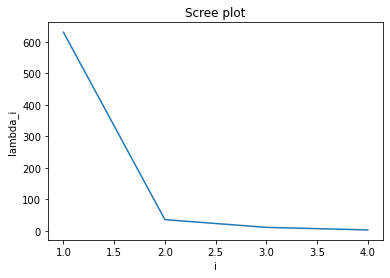

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(eigs)+1), np.array(eigs.tolist()))
plt.title(label="Scree plot")
plt.xlabel("i")
plt.ylabel("lambda_i")
plt.show()

There is an elbow in the plot at $i = 2$, meaning all eigenvalues after $\lambda_1$ are relatively small and about the same size. In this case, it appears that the first principal component effectively summarize the total sample variance.

Finally, we can visualize the two dimensional projection using a scatter plot.

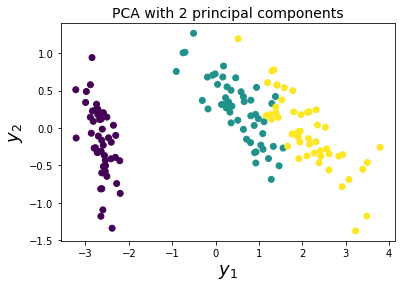

In [13]:
plt.title("PCA with 2 principal components", fontsize=14)
plt.scatter(X2D_diy[:, 0], X2D_diy[:,1], c=iris['target'])
plt.xlabel("$y_1$", fontsize=18)
plt.ylabel("$y_2$", fontsize=18)
plt.show()

### PCA using scikit-learn

Now we'll calculate the PCA projection using scikit-learn. Notice that scikit-learn will mean center the data itself.

In [14]:
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

Instead of specifing the number of components in the call to PCA above, we can also set $\operatorname{n\_components}=0.95$ to obtain the number of dimensions which capture 95% of the variance in the data. Or we could pass in no arguments to get the full SVD and plot a scree plot.

Below, we check that sklearn PCA and the one calculated with SVD directly give the same answer.

In [15]:
np.max(X2D - X2D_diy)

2.748330173586095

The non-uniquness of the PCA leads to a large difference. However, this can be fixed by inspecting the projections and adjusting:

In [16]:
X2D_diy[:,1] = - X2D_diy[:,1]
np.max(X2D - X2D_diy)

1.3322676295501878e-15

The explained variance ratio holds the proportion of variance explained by the first two sample principal components, and is given by

In [17]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

#### Computational complexity

Let $n_{max} = \operatorname{max}(m,n)$ and $n_{min} = \operatorname{min}(m,n)$. If $n_{max} < 500$ and $d$ is less than $80\%$ of $n_{min}$, then scikit-learn uses the full SVD approach which has a complexity of $O(n_{max}^2 n_{min})$, otherwise it uses randomized PCA which has a complexity of $O(n_{max}^2 d)$ (cf. [here](https://scikit-learn.org/stable/modules/decomposition.html#pca-using-randomized-svd) and {% cite Gron2017HandsOnML %}).

There are many more variations of PCA, and other dimensionality reduction algorithms. See [Decomposing signals in components (matrix factorization problems)](https://scikit-learn.org/stable/modules/decomposition.html#decomposing-signals-in-components-matrix-factorization-problems) in the scikit-learn documentation, for example.

{% bibliography --cited %}